<a href="https://colab.research.google.com/github/star-plant/ENFU-AI-SEMI/blob/main/study/snntorch/tutorial_3_feedforward_snn_kr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="400">](https://github.com/jeshraghian/snntorch/)


# snnTorch - A Feedforward Spiking Neural Network
## Tutorial 3
### By Jason K. Eshraghian (www.ncg.ucsc.edu)

<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/tutorial_3_feedforward_snn.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub-Mark-Light-120px-plus.png?raw=true' width="28">](https://github.com/jeshraghian/snntorch/) [<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub_Logo_White.png?raw=true' width="80">](https://github.com/jeshraghian/snntorch/)


The snnTorch tutorial series is based on the following paper. If you find these resources or code useful in your work, please consider citing the following source:

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". Proceedings of the IEEE, 111(9) September 2023.](https://ieeexplore.ieee.org/abstract/document/10242251) </cite>

# Introduction

이 튜토리얼에서 여러분은 다음을 배우게 됩니다:

* Leaky Integrate-and-Fire(LIF) 뉴런을 단순화하여 딥러닝에 적합하게 만드는 방법
* 피드포워드 스파이킹 신경망(SNN) 구현

다음 셀을 클릭한 후 `Shift+Enter`를 눌러 snnTorch의 최신 PyPi 배포판을 설치하세요.


In [1]:
!pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 4.9 MB/s eta 0:00:00


In [2]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [3]:
#@title Plotting Settings
def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max1=1.25, ylim_max2=1.25):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True,
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_ylim([0, ylim_max1])
  ax[0].set_xlim([0, 200])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[2], s=400, c="black", marker="|")
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes")
  plt.yticks([])

  plt.show()

def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,7), sharex=True,
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes
  splt.raster(spk_in[:,0], ax[0], s=0.03, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.05, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_ylim([0, 10])

  plt.show()

# 1. Leaky Integrate-and-Fire 뉴런 모델 단순화

이전 튜토리얼에서 우리는 직접 LIF 뉴런 모델을 설계했습니다.
하지만 이 과정에서 $R$, $C$, $\Delta t$, $U_{\rm thr}$, 리셋 메커니즘 선택 등 조정해야 할 하이퍼파라미터가 많아졌고, 전체 SNN으로 확장할수록 관리가 복잡해집니다.
따라서 몇 가지 단순화를 해보겠습니다.

---

## 1.1 감쇠율(Decay Rate) $\beta$

앞서 Euler 방법을 사용해 수동 막(passive membrane) 모델의 해는 다음과 같이 유도되었습니다.

$$
U(t+\Delta t) = \left(1 - \frac{\Delta t}{\tau}\right) U(t) + \frac{\Delta t}{\tau} I_{\rm in}(t) R \tag{1}
$$

입력 전류가 없는 경우 $I_{\rm in}(t) = 0 \ \text{A}$이면,

$$
U(t+\Delta t) = \left(1 - \frac{\Delta t}{\tau}\right) U(t) \tag{2}
$$

여기서 $U(t+\Delta t)/U(t)$의 비율을 막 전위의 감쇠율(Decay Rate), 즉 역시정수(Inverse Time Constant)라 정의하면,

$$
U(t+\Delta t) = \beta U(t) \tag{3}
$$

(1)로부터,

$$
\beta = \left(1 - \frac{\Delta t}{\tau}\right) \tag{4}
$$

정확도를 위해서는 $\Delta t \ll \tau$ 여야 합니다.

---

## 1.2 가중 입력 전류

시간 $t$를 연속 시간이 아닌 시퀀스의 타임스텝으로 가정하면, $\Delta t = 1$로 설정할 수 있습니다.
또한 단순화를 위해 $R = 1$로 두면, (4)로부터:

$$
\beta = \left(1 - \frac{1}{C}\right) \implies (1-\beta) I_{\rm in} = \frac{1}{\tau} I_{\rm in} \tag{5}
$$

즉, 입력 전류는 $(1-\beta)$로 가중됩니다.
여기에 "입력 전류가 즉시 막 전위에 반영된다"는 가정을 더하면:

$$
U[t+1] = \beta U[t] + (1-\beta) I_{\rm in}[t+1] \tag{6}
$$

시간이 이산화되었으므로, 각 타임스텝 $t$는 뉴런이 최대 한 번만 스파이크를 낼 수 있을 만큼 짧다고 가정합니다.

딥러닝에서는 입력 가중치가 종종 학습 가능한 파라미터입니다.
물리적 가정을 조금 완화하여, (6)의 $(1-\beta)$ 효과를 학습 가능한 가중치 $W$에 흡수하고, $I_{\rm in}[t]$을 입력 $X[t]$로 대체하면:

$$
W X[t] = I_{\rm in}[t] \tag{7}
$$

이는 $X[t]$가 입력 전압 또는 스파이크이고, 시냅스 전도율 $W$로 스케일링되어 뉴런에 주입되는 전류를 만든다는 의미입니다.
따라서:

$$
U[t+1] = \beta U[t] + W X[t+1] \tag{8}
$$

이후 시뮬레이션에서는 $W$와 $\beta$의 효과가 분리됩니다.

* $W$: 학습 가능한 파라미터
* $\beta$: 독립적으로 설정하는 유일한 하이퍼파라미터

---

## 1.3 스파이킹과 리셋

이제 스파이크와 리셋 메커니즘을 도입합니다.
막 전위가 임계값을 넘으면 뉴런은 출력 스파이크를 방출합니다:

$$
S[t] =
\begin{cases}
1, & \text{if } U[t] > U_{\rm thr} \\
0, & \text{otherwise}
\end{cases} \tag{9}
$$

스파이크가 발생하면 막 전위를 리셋해야 합니다.
감산 리셋(reset-by-subtraction) 메커니즘은 다음과 같이 표현됩니다:

$$
U[t+1] =
\underbrace{\beta U[t]}_{\text{decay}} +
\underbrace{W X[t+1]}_{\text{input}} -
\underbrace{S[t] U_{\rm thr}}_{\text{reset}} \tag{10}
$$

여기서 $W$는 학습 가능한 파라미터이고, $U_{\rm thr}$는 보통 1로 두지만 조정 가능하므로, 남는 유일한 하이퍼파라미터는 $\beta$입니다.
이로써 복잡한 부분은 모두 끝났습니다.

> 참고: 일부 구현에서는 (9)에서 $S[t] \rightarrow S[t+1]$, (10)에서 $X[t] \rightarrow X[t+1]$로 바꾸기도 합니다.
> snnTorch는 (9)와 (10)의 형태를 그대로 사용하며, 이는 성능 차이 없이 RNN 표현으로 직관적으로 매핑되기 때문입니다.


## 1.4 Code Implementation
이 뉴런을 Python으로 구현하면 다음과 같습니다:

In [4]:
def leaky_integrate_and_fire(mem, x, w, beta, threshold=1):
  spk = (mem > threshold) # if membrane exceeds threshold, spk=1, else, 0
  mem = beta * mem + w*x - spk*threshold
  return spk, mem

$\beta$ 값을 설정하는 방법은 두 가지가 있습니다.

1. 식 (3)을 사용해 계산하는 방법
2. 값을 직접 하드코딩하는 방법

여기서는 시연을 위해 (3)을 사용하지만, 이후에는 생물학적 정확성보다는 동작하는 모델에 집중하기 위해 하드코딩할 것입니다.

식 (3)은 $\beta$가 두 연속 시점의 막 전위 비율임을 알려줍니다.
이 값을 구하기 위해 [Tutorial 2](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)에서 유도했던 **연속 시간 기반 방정식**(입력 전류 없음 가정)을 사용합니다:

$$
U(t) = U_0 e^{-\frac{t}{\tau}}
$$

여기서 $U_0$는 $t=0$일 때의 초기 막 전위입니다.
시간을 이산 스텝 $t, (t+\Delta t), (t+2\Delta t) \dots$로 계산한다고 가정하면, 연속된 두 시점 사이의 막 전위 비율은 다음과 같습니다:

$$
\beta = \frac{U_0 e^{-\frac{t+\Delta t}{\tau}}}{U_0 e^{-\frac{t}{\tau}}}
     = \frac{U_0 e^{-\frac{t + 2\Delta t}{\tau}}}{U_0 e^{-\frac{t+\Delta t}{\tau}}}
     = \dots
$$

따라서,

$$
\implies \beta = e^{-\frac{\Delta t}{\tau}}
$$


In [5]:
# set neuronal parameters
delta_t = torch.tensor(1e-3)
tau = torch.tensor(5e-3)
beta = torch.exp(-delta_t/tau)

print(f"The decay rate is: {beta:.3f}")

The decay rate is: 0.819


단계 전압 입력에 대해 뉴런이 올바르게 반응하는지 빠르게 시뮬레이션해 봅시다.


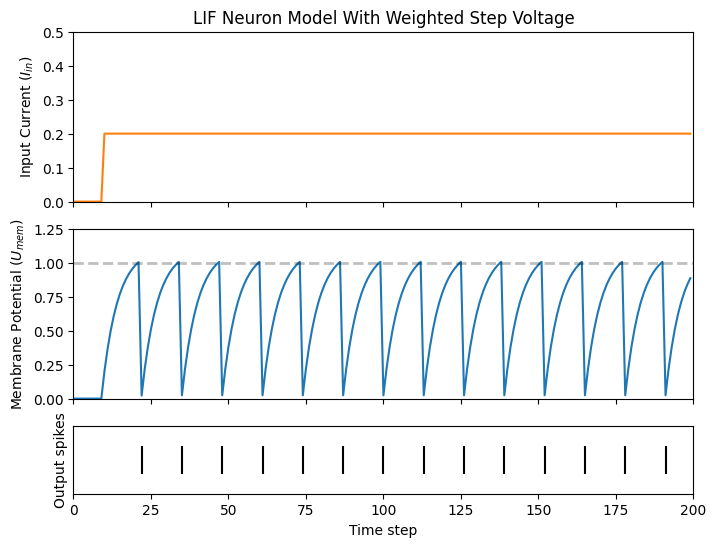

In [6]:
num_steps = 200

# initialize inputs/outputs + small step current input
x = torch.cat((torch.zeros(10), torch.ones(190)*0.5), 0)
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron parameters
w = 0.4
beta = 0.819

# neuron simulation
for step in range(num_steps):
  spk, mem = leaky_integrate_and_fire(mem, x[step], w=w, beta=beta)
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(x*w, mem_rec, spk_rec, thr_line=1,ylim_max1=0.5,
                 title="LIF Neuron Model With Weighted Step Voltage")

# 2. `Leaky` Neuron Model in snnTorch

이전 튜토리얼에서 `snn.Lapicque`를 사용했던 것과 비슷하게, `snn.Leaky`를 인스턴스화하면 거의 동일한 뉴런을 구현할 수 있습니다.
다만, 하이퍼파라미터 수가 더 적습니다.




In [7]:
lif1 = snn.Leaky(beta=0.8)

뉴런 모델은 이제 `lif1`에 저장되어 있습니다. 이 뉴런을 사용하려면 다음과 같습니다.

**입력**

* `cur_in`: $W \times X[t]$의 각 요소가 순차적으로 입력으로 전달됩니다.
* `mem`: 이전 시점의 막 전위 $U[t-1]$도 입력으로 전달됩니다.

**출력**

* `spk_out`: 현재 시점의 출력 스파이크 $S[t]$ — 스파이크가 있으면 '1', 없으면 '0'
* `mem`: 현재 시점의 막 전위 $U[t]$

이 값들은 모두 `torch.Tensor` 타입이어야 합니다.
여기서는 입력 전류가 `snn.Leaky` 뉴런에 전달되기 전에 이미 가중치가 곱해졌다고 가정합니다.
이 부분은 네트워크 규모의 모델을 구성할 때 더 명확해집니다.
또한, 식 (10)은 일반성을 잃지 않으면서 한 스텝 이전으로 시간 시프트되었습니다.


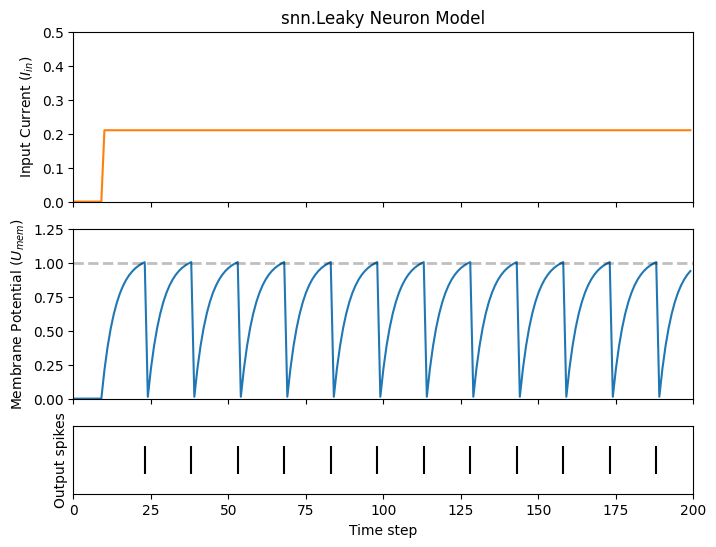

In [8]:
# Small step current input
w=0.21
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*w), 0)
mem = torch.zeros(1)
spk = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron simulation
for step in range(num_steps):
  spk, mem = lif1(cur_in[step], mem)
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, ylim_max1=0.5,
                 title="snn.Leaky Neuron Model")

이 플롯을 직접 유도한 leaky integrate-and-fire 뉴런과 비교해 보세요.
막 전위 리셋이 약간 더 약한데, 즉 *소프트 리셋(soft reset)*을 사용합니다.
이는 몇몇 딥러닝 벤치마크에서 더 나은 성능을 내기 위해 의도적으로 적용된 것입니다.
여기서 사용된 식은 다음과 같습니다.

$$
U[t+1] =
\underbrace{\beta U[t]}_{\text{decay}} +
\underbrace{W X[t+1]}_{\text{input}} -
\underbrace{\beta S[t] U_{\rm thr}}_{\text{soft reset}}
\tag{11}
$$

이 모델은 Lapicque 뉴런 모델에서 설명한 것과 동일하게,
`reset_mechanism`과 `threshold`를 선택적으로 입력 인자로 받을 수 있습니다.


# 3. A Feedforward Spiking Neural Network

지금까지는 하나의 뉴런이 입력 자극에 어떻게 반응하는지만 살펴봤습니다.
snnTorch를 사용하면 이를 쉽게 심층 신경망으로 확장할 수 있습니다.
이번 섹션에서는 784-1000-10 구조의 3계층 완전연결 신경망을 만들겠습니다.
지금까지의 시뮬레이션과 비교하면, 각 뉴런은 훨씬 더 많은 입력 스파이크를 적분하게 됩니다.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_8_fcn.png?raw=true' width="600">
</center>

PyTorch는 뉴런 간의 연결을 구성하는 데 사용되고, snnTorch는 뉴런을 생성하는 데 사용됩니다.
먼저, 모든 계층을 초기화합니다.


In [9]:
# layer parameters
num_inputs = 784
num_hidden = 1000
num_outputs = 10
beta = 0.99

# initialize layers
fc1 = nn.Linear(num_inputs, num_hidden)
lif1 = snn.Leaky(beta=beta)
fc2 = nn.Linear(num_hidden, num_outputs)
lif2 = snn.Leaky(beta=beta)

다음으로, 각 스파이킹 뉴런의 은닉 변수(hidden variables)와 출력을 초기화합니다.
네트워크 크기가 커질수록 이 과정은 점점 번거로워집니다.
이를 간단히 처리하기 위해 정적 메서드 `init_leaky()`를 사용할 수 있습니다.

snnTorch의 모든 뉴런은 동일한 문법을 따르는 자체 초기화 메서드를 가지고 있습니다. 예: `init_lapicque()`
첫 번째 순전파(forward pass) 시 입력 데이터의 차원에 따라 은닉 상태의 형태(shape)가 자동으로 초기화됩니다.


In [10]:
# Initialize hidden states
mem1 = lif1.init_leaky()
mem2 = lif2.init_leaky()

# record outputs
mem2_rec = []
spk1_rec = []
spk2_rec = []

네트워크에 전달할 입력 스파이크 열(spike train)을 생성합니다.
784개의 입력 뉴런에 대해 200 타임스텝을 시뮬레이션하므로, 원래 입력 데이터의 크기는 $200 \times 784$입니다.

하지만 신경망은 일반적으로 미니배치 단위로 데이터를 처리합니다.
snnTorch는 **time-first** 차원 순서를 사용합니다.

$$
[time \times batch\_size \times feature\_dimensions]
$$

따라서 `dim=1`에 대해 'unsqueeze'를 적용하여 '한 배치'의 데이터를 나타내야 합니다.
이 경우 입력 텐서의 크기는 반드시 $200 \times 1 \times 784$가 되어야 합니다.


In [15]:
spk_in = spikegen.rate_conv(torch.rand((200, 784))).unsqueeze(1)
print(f"Dimensions of spk_in: {spk_in.size()}")

Dimensions of spk_in: torch.Size([200, 1, 784])


이제 드디어 전체 시뮬레이션을 실행할 차례입니다.
PyTorch와 snnTorch가 함께 동작하는 방식을 직관적으로 이해하는 방법은,
PyTorch는 뉴런들을 서로 연결해주고, snnTorch는 그 결과를 스파이킹 뉴런 모델에 로드하는 것으로 생각하는 것입니다.
코드 작성 관점에서 보면, 이러한 스파이킹 뉴런들은 시간에 따라 변하는 활성화 함수처럼 취급할 수 있습니다.

아래는 동작 과정을 순차적으로 정리한 것입니다.

* `spk_in`에서 온 $i$번째 입력이 $j$번째 뉴런에 들어가면, `nn.Linear`에서 초기화된 파라미터로 가중치가 곱해집니다: $X_{i} \times W_{ij}$
* 이렇게 생성된 입력 전류 항이 식 (10)에 따라 스파이킹 뉴런의 $U[t+1]$에 기여합니다.
* $U[t+1] > U_{\rm thr}$이면, 해당 뉴런에서 스파이크가 발생합니다.
* 이 스파이크는 두 번째 계층의 가중치와 곱해지고, 위 과정을 모든 입력·가중치·뉴런에 대해 반복합니다.
* 스파이크가 발생하지 않으면, 다음(시냅스 이후) 뉴런에는 아무것도 전달되지 않습니다.

지금까지의 시뮬레이션과 다른 점은, 이제 입력 전류를 직접 $W$로 설정하는 대신,
`nn.Linear`에서 생성된 가중치로 스케일링한다는 것입니다.


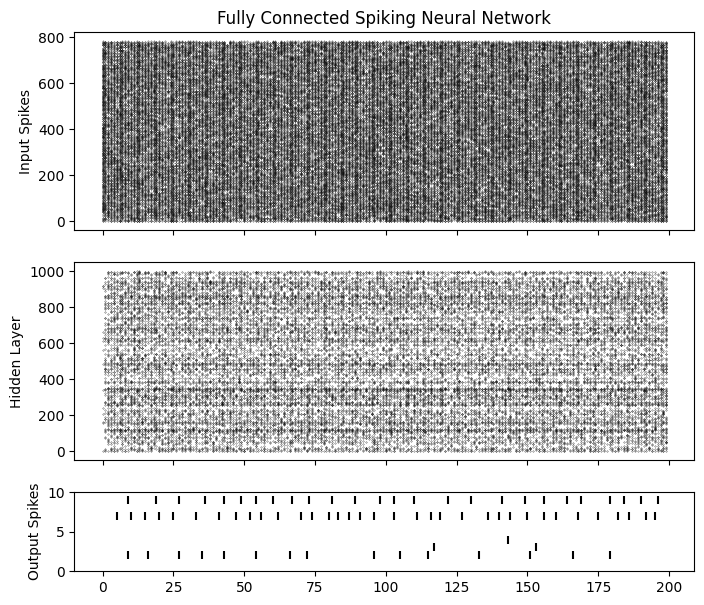

In [12]:
# network simulation
for step in range(num_steps):
    cur1 = fc1(spk_in[step]) # post-synaptic current <-- spk_in x weight
    spk1, mem1 = lif1(cur1, mem1) # mem[t+1] <--post-syn current + decayed membrane
    cur2 = fc2(spk1)
    spk2, mem2 = lif2(cur2, mem2)

    mem2_rec.append(mem2)
    spk1_rec.append(spk1)
    spk2_rec.append(spk2)

# convert lists to tensors
mem2_rec = torch.stack(mem2_rec)
spk1_rec = torch.stack(spk1_rec)
spk2_rec = torch.stack(spk2_rec)

plot_snn_spikes(spk_in, spk1_rec, spk2_rec, "Fully Connected Spiking Neural Network")

> 오류가 발생하면 네트워크와 파라미터를 다시 초기화해보세요.

이 단계에서는 스파이크에 아직 아무런 실제 의미가 없습니다.
입력과 가중치가 모두 무작위로 초기화되어 있고, 학습이 전혀 이루어지지 않았기 때문입니다.
하지만 스파이크가 1층에서 출력층까지 전파되는 모습은 보일 것입니다.
만약 스파이크가 전혀 보이지 않는다면, 가중치 초기화에서 운이 나빴을 수 있으니
마지막 네 개의 코드 블록을 다시 실행해보는 것이 좋습니다.

`spikeplot.spike_count`를 사용하면 출력층의 스파이크 수를 집계할 수 있습니다.
아래의 애니메이션은 생성하는 데 시간이 걸릴 수 있습니다. <br>

> 참고: 만약 로컬 데스크톱에서 노트북을 실행 중이라면, 아래 줄의 주석을 해제하고 `ffmpeg.exe` 경로를 수정하세요.


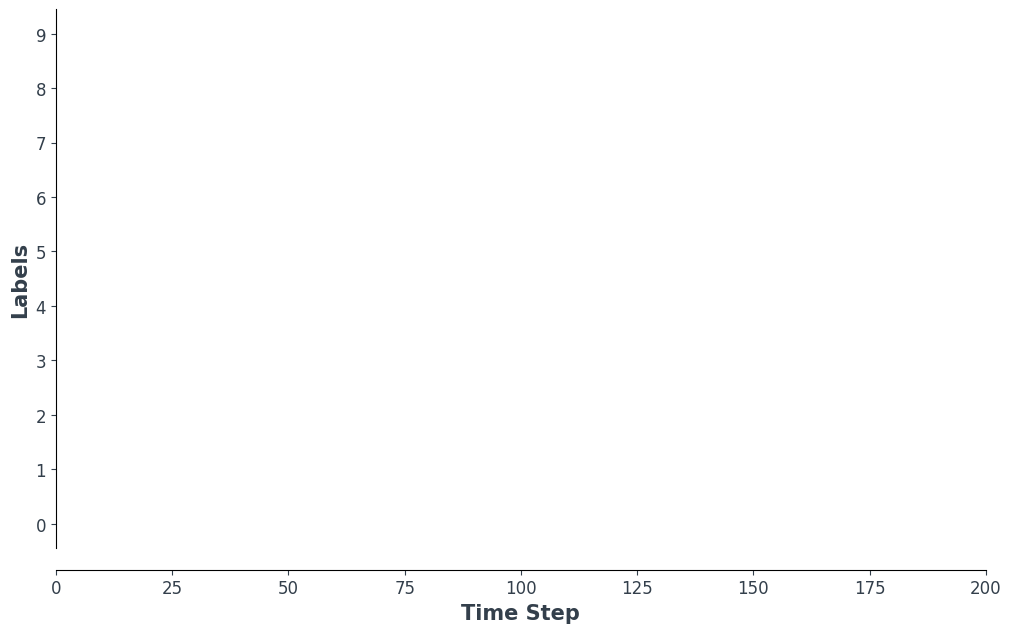

In [13]:
from IPython.display import HTML

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
spk2_rec = spk2_rec.squeeze(1).detach().cpu()

# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

#  Plot spike count histogram
anim = splt.spike_count(spk2_rec, fig, ax, labels=labels, animate=True)
HTML(anim.to_html5_video())
# anim.save("spike_bar.mp4")

`spikeplot.traces`를 사용하면 막전위 변화를 시각화할 수 있습니다.
출력 뉴런 10개 중 9개를 그래프로 표시하겠습니다.
위에서 만든 애니메이션과 래스터 플롯과 비교하여, 각 뉴런을 서로 매칭할 수 있는지 확인해 보세요.


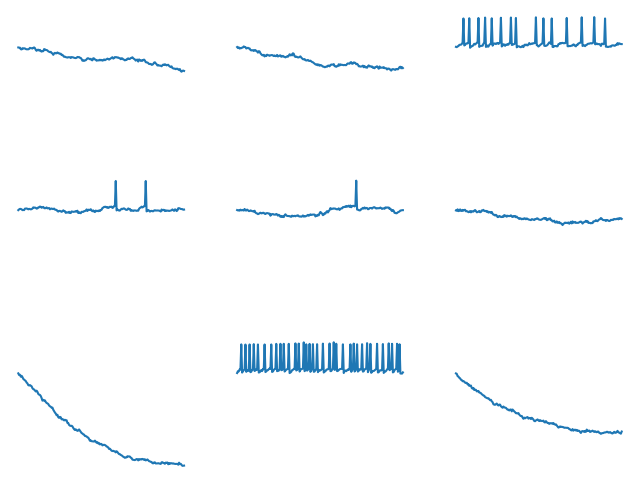

In [14]:
# plot membrane potential traces
splt.traces(mem2_rec.squeeze(1), spk=spk2_rec.squeeze(1))
fig = plt.gcf()
fig.set_size_inches(8, 6)

일부 뉴런이 발화하고 다른 뉴런은 완전히 죽어 있는 경우는 꽤 정상입니다.
다시 말하지만, 가중치가 학습되기 전까지는 이러한 스파이크에 실제 의미는 없습니다.


# Conclusion

이번 내용에서는 leaky integrate-and-fire 뉴런 모델을 단순화하는 방법과 이를 사용해 스파이킹 신경망을 구축하는 방법을 다뤘습니다. 실제로 네트워크를 학습할 때는 `snn.Lapicque`보다 `snn.Leaky`를 사용하는 경우가 거의 항상 선호되는데, 이는 하이퍼파라미터 탐색 공간이 더 작기 때문입니다.

[Tutorial 4](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)에서는 2차 모델인 `snn.Synaptic`과 `snn.Alpha`에 대해 자세히 설명합니다.
다음 튜토리얼은 네트워크 학습에 필수적인 내용이 아니므로, 바로 snnTorch로 딥러닝을 진행하고 싶다면 [Tutorial 5](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)로 건너뛰어도 됩니다.

참고로, 문서 자료는 [여기](https://snntorch.readthedocs.io/en/latest/snntorch.html)에서 확인할 수 있습니다.

이 프로젝트가 마음에 드신다면, GitHub에서 ⭐을 눌러 주시면 가장 쉽고 좋은 방식으로 프로젝트를 지원하실 수 있습니다.


## Further Reading
* [Check out the snnTorch GitHub project here.](https://github.com/jeshraghian/snntorch)
* [snnTorch documentation](https://snntorch.readthedocs.io/en/latest/snntorch.html) of the Lapicque, Leaky, Synaptic, and Alpha models
* [*Neuronal Dynamics:
From single neurons to networks and models of cognition*](https://neuronaldynamics.epfl.ch/index.html) by
Wulfram Gerstner, Werner M. Kistler, Richard Naud and Liam Paninski.
* [Theoretical Neuroscience: Computational and Mathematical Modeling of Neural Systems](https://mitpress.mit.edu/books/theoretical-neuroscience) by Laurence F. Abbott and Peter Dayan